In [11]:
import numpy as np
import pandas as pd
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions as dist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(0)
torch.manual_seed(0)
pyro.set_rng_seed(0)


Note: The models M1 and M2 can be found in model_aaron or model_manjaree folder (time split models)

# M3: KMeans (k=8)

In [2]:
import pandas as pd

# Define the path to your CSV file
file_path = "cleaned_hurricane_damage_data.csv"

# Load the CSV file
df = pd.read_csv(file_path)

# Display the first 5 rows
print(df.head())


   B01001_001E  Household Income Distribution  Median Household Income  \
0       1675.0                          860.0                  75444.0   
1       2221.0                         1070.0                 140313.0   
2       1904.0                         1098.0                  83750.0   
3       1147.0                          517.0                  62054.0   
4       4946.0                         3231.0                  29737.0   

   B19001_002E  B19001_003E  B19001_004E  B19001_005E  B19001_006E  \
0         23.0         98.0         21.0         10.0         52.0   
1         45.0         24.0         16.0         17.0          0.0   
2         72.0         76.0         50.0         72.0          0.0   
3          0.0          0.0          0.0         60.0         61.0   
4        373.0        471.0        391.0        176.0        217.0   

   B19001_007E  B19001_008E  ...  Longitude  storm_county    ppt_mean  \
0         10.0          9.0  ...   -80.3117  201007_12086  11

/var/folders/p3/9thmbny930lcn8vcx6g216br0000gp/T/ipykernel_51731/4225642204.py:7: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ─────────────────────────── Column Mapping ───────────────────────────
census_svi_column_mapping = {
    'B01001_001E': 'Total Population',
    'B19001_001E': 'Household Income Distribution',
    'B19013_001E': 'Median Household Income',
    'B19001_002E': 'Income Bracket 1',
    'B19001_003E': 'Income Bracket 2',
    'B19001_004E': 'Income Bracket 3',
    'B19001_005E': 'Income Bracket 4',
    'B19001_006E': 'Income Bracket 5',
    'B19001_007E': 'Income Bracket 6',
    'B19001_008E': 'Income Bracket 7',
    'B19001_009E': 'Income Bracket 8',
    'B19001_010E': 'Income Bracket 9',
    'B19001_011E': 'Income Bracket 10',
    'B19001_012E': 'Income Bracket 11',
    'B19001_013E': 'Income Bracket 12',
    'B19001_014E': 'Income Bracket 13',
    'B19001_015E': 'Income Bracket 14',
    'B19001_016E': 'Income Bracket 15',
    'B19001_017E': 'Income Bracket 16',
    'state': 'State',
    'county': 'County',
    'tract': 'Census Tract',
    'year': 'Year',
    'STATE_COUNTY_FIPS': 'State-County FIPS Code',
    'GEOID': 'Geographic Identifier',
    'FIPS': 'FIPS Code',
    'RPL_THEMES': 'SVI Themes',
    'CZ_FIPS': 'Combined Statistical Area FIPS',
    'ST': 'State Abbreviation',
    'LOCATION': 'Location',
    'E_TOTPOP': 'Estimated Total Population',
    'M_TOTPOP': 'Margin of Error Total Population',
    'E_HU': 'Estimated Housing Units',
    'M_HU': 'Margin of Error Housing Units',
    'E_UNEMP': 'Estimated Unemployed',
    'M_UNEMP': 'Margin of Error Unemployed',
    'E_LIMENG': 'Estimated Limited English Proficiency',
    'M_LIMENG': 'Margin of Error Limited English Proficiency',
    'E_MUNIT': 'Estimated Multi-Unit Housing',
    'M_MUNIT': 'Margin of Error Multi-Unit Housing',
    'E_MOBILE': 'Estimated Mobile Homes',
    'M_MOBILE': 'Margin of Error Mobile Homes',
    'E_CROWD': 'Estimated Crowded Housing',
    'M_CROWD': 'Margin of Error Crowded Housing',
    'E_NOVEH': 'Estimated No Vehicle',
    'M_NOVEH': 'Margin of Error No Vehicle',
    'DAMAGE_PROPERTY': 'Damage to Property',
    'DAMAGE_CROPS': 'Damage to Crops',
    'BEGIN_YEARMONTH': 'Begin Year-Month',
    'LAT': 'Latitude',
    'LON': 'Longitude',
    'storm_county': 'Storm County'
}

# ─────────────────────────── Feature Engineering ───────────────────────────
def add_features(df):
    df = df.copy()
    eps = 1e-6

    df['pct_unemp']  = df['Estimated Unemployed'] / (df['Total Population'] + eps)
    df['pct_limm']   = df['Estimated Limited English Proficiency'] / (df['Total Population'] + eps)
    df['pct_noveh']  = df['Estimated No Vehicle'] / (df['Total Population'] + eps)
    df['pct_mobile'] = df['Estimated Mobile Homes'] / (df['Estimated Housing Units'] + eps)
    df['pct_crowd']  = df['Estimated Crowded Housing'] / (df['Estimated Housing Units'] + eps)

    lows  = ['Income Bracket 1', 'Income Bracket 2', 'Income Bracket 3']
    highs = ['Income Bracket 14', 'Income Bracket 15', 'Income Bracket 16']
    df['low_inc_pct']  = df[lows].sum(axis=1) / (df['Household Income Distribution'] + eps)
    df['high_inc_pct'] = df[highs].sum(axis=1) / (df['Household Income Distribution'] + eps)
    df['inc_ineq']     = df['high_inc_pct'] / (df['low_inc_pct'] + eps)

    df['log_pop']    = np.log1p(df['Total Population'])
    df['log_medinc'] = np.log1p(df['Median Household Income'])
    df['pop_poverty'] = df['Total Population'] * df['low_inc_pct']

    df['Begin Year-Month'] = pd.to_datetime(df['Begin Year-Month'], format='%Y%m')
    df['month'] = df['Begin Year-Month'].dt.month

    return df


# ─────────────────────────── Main Pipeline ───────────────────────────
# Load and rename
full = pd.read_csv("cleaned_hurricane_damage_data.csv")
full = full.rename(columns=census_svi_column_mapping)
full = full.loc[:, ~full.columns.duplicated()]

# Remove rows with no damage
full = full[full['Damage to Property'] != 0].dropna(subset=['Damage to Property'])

# Add derived features
full = add_features(full)

# Group target (sum) and features (mean)
y_group = full.groupby(['Year', 'State-County FIPS Code'])[['Damage to Property']].sum().reset_index()
x_group = full.groupby(['Year', 'State-County FIPS Code'])[features + ['Latitude', 'Longitude']].mean().reset_index()

# Merge target and predictors
full_data = y_group.merge(x_group, on=['Year', 'State-County FIPS Code'])

# ─────────────────────────── Train-Test Split ───────────────────────────
train_full = full_data[full_data['Year'] < 2020].reset_index(drop=True)
test_full  = full_data[full_data['Year'] == 2020].reset_index(drop=True)

# ─────────────────────────── Spatial Clustering ───────────────────────────
coords = train_full[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=10, random_state=0).fit(coords)
train_full['spatial_cluster'] = kmeans.labels_

print(f"Train size: {train_full.shape[0]} | Test size: {test_full.shape[0]}")


Train size: 746 | Test size: 199


/var/folders/p3/9thmbny930lcn8vcx6g216br0000gp/T/ipykernel_51731/1563255365.py:114: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  full = pd.read_csv("cleaned_hurricane_damage_data.csv")


In [5]:
def prepare_Xy(df):
    df = df.dropna(subset=features + ['Damage to Property'])
    X = df[features].values
    y = np.log1p(df['Damage to Property'].values)
    return X, y
    

def guide(X, y=None):
    n = X.shape[1]
    pyro.sample("intercept",
        dist.Normal(pyro.param("intercept_loc", torch.tensor(0.)),
                    pyro.param("intercept_scale", torch.tensor(1.), constraint=dist.constraints.positive)))
    pyro.sample("weights",
        dist.Normal(pyro.param("weights_loc", torch.zeros(n)),
                    pyro.param("weights_scale", torch.ones(n), constraint=dist.constraints.positive)).to_event(1))
    pyro.sample("sigma",
        dist.HalfNormal(pyro.param("sigma_loc", torch.tensor(1.), constraint=dist.constraints.positive)))

def safe_metrics(y_true, y_pred):
    mask = (
        (~np.isnan(y_true)) & (~np.isnan(y_pred)) &
        (~np.isinf(y_true)) & (~np.isinf(y_pred))
    )
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    return mae, rmse


=== Processing Fold 1/8 ===
Epoch 500: Train Loss=3167290.1, Val Loss=18078.5
Epoch 1000: Train Loss=30180.1, Val Loss=15973.4
Epoch 1500: Train Loss=76009.4, Val Loss=7379.5
Epoch 2000: Train Loss=76935724.7, Val Loss=1061.7

=== Processing Fold 2/8 ===
Epoch 500: Train Loss=106382.7, Val Loss=64341.0
Epoch 1000: Train Loss=14109.8, Val Loss=5255512.1
Epoch 1500: Train Loss=389756.0, Val Loss=141849.6
Epoch 2000: Train Loss=78812.6, Val Loss=347507.1

=== Processing Fold 3/8 ===
Epoch 500: Train Loss=75668.6, Val Loss=1440.7
Epoch 1000: Train Loss=53601.1, Val Loss=6318.7
Epoch 1500: Train Loss=4579.5, Val Loss=3529641.0
Epoch 2000: Train Loss=28357.8, Val Loss=28008.0

=== Processing Fold 4/8 ===
Epoch 500: Train Loss=10533.8, Val Loss=1826.4
Epoch 1000: Train Loss=17103.3, Val Loss=404.9
Epoch 1500: Train Loss=121223.5, Val Loss=1504.2
Epoch 2000: Train Loss=7380.9, Val Loss=1065.3

=== Processing Fold 5/8 ===
Epoch 500: Train Loss=20998268.9, Val Loss=1555994.0
Epoch 1000: Train L

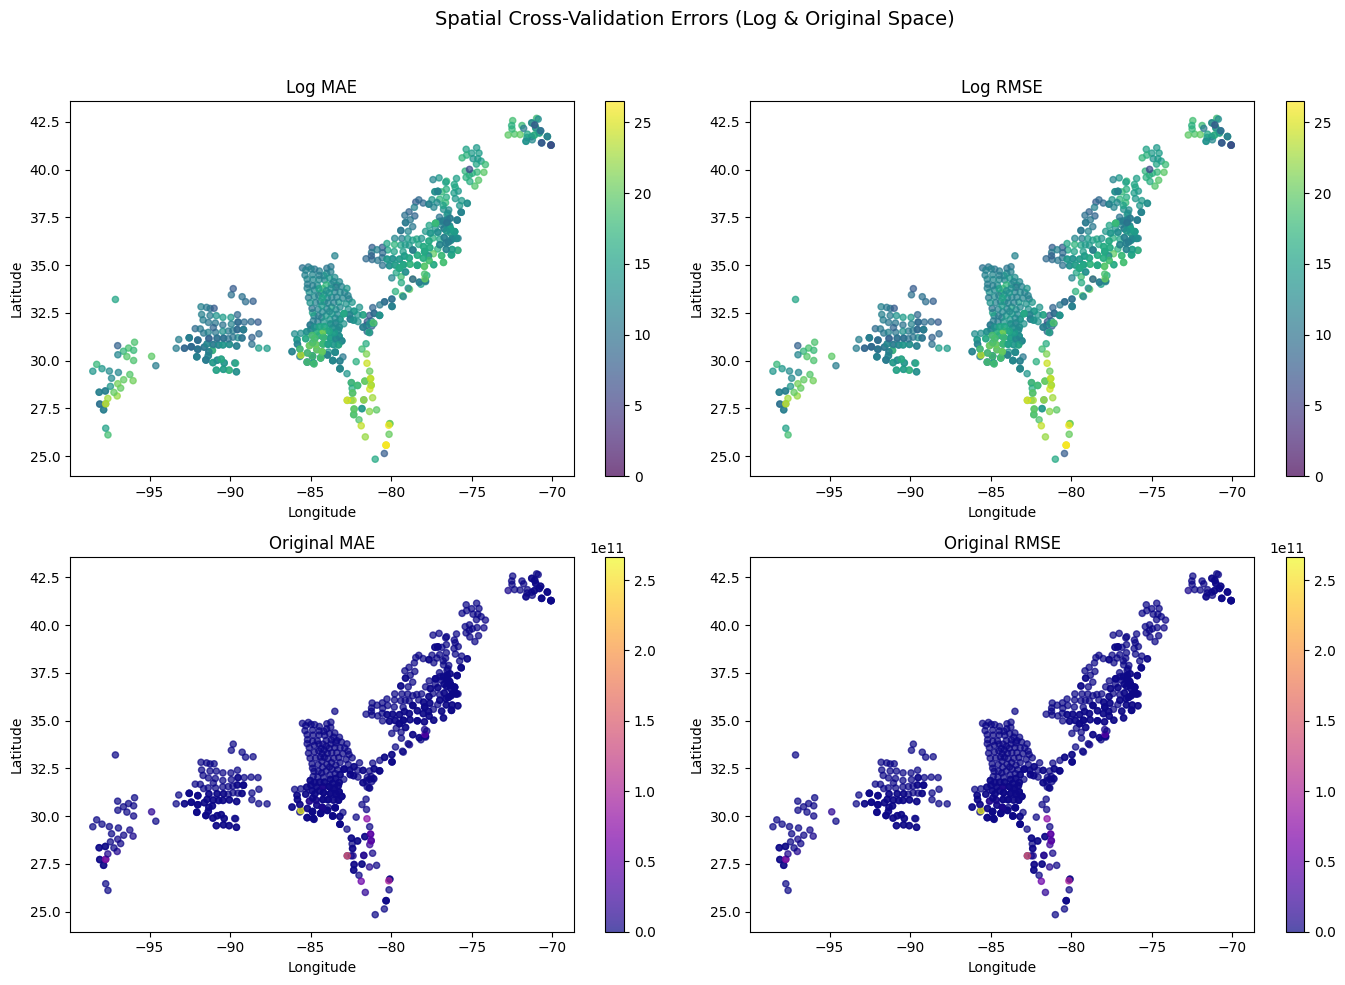

In [6]:
def spatial_cv_evaluation(train_data, features, n_clusters=8, n_epochs=2000):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    import pyro
    import pyro.distributions as dist
    from pyro.infer import SVI, Trace_ELBO
    from pyro.optim import Adam
    import torch
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    coords = train_data[['Latitude', 'Longitude']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

    fold_metrics = []
    error_data = {
        'true_log': [], 'pred_log': [],
        'true_orig': [], 'pred_orig': [],
        'Latitude': [], 'Longitude': []
    }

    for fold in range(n_clusters):
        print(f"\n=== Processing Fold {fold+1}/{n_clusters} ===")

        train_fold = train_data[kmeans.labels_ != fold]
        val_fold   = train_data[kmeans.labels_ == fold]
        if val_fold.empty:
            print(f"Skipping empty fold {fold}")
            continue

        try:
            X_train, y_train = prepare_Xy(train_fold)
            X_val, y_val     = prepare_Xy(val_fold)
        except KeyError as e:
            print(f"Missing feature: {e}")
            continue

        if X_train.shape[0] == 0 or X_val.shape[0] == 0:
            print(f"Empty data in fold {fold}")
            continue

        scaler = StandardScaler().fit(X_train)
        X_train_t = torch.tensor(scaler.transform(X_train), dtype=torch.float32)
        X_val_t   = torch.tensor(scaler.transform(X_val), dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)
        y_val_t   = torch.tensor(y_val, dtype=torch.float32)

        def model(X, y=None):
            n_features = X.shape[1]
            intercept = pyro.sample("intercept", dist.Normal(0., 10.))
            weights   = pyro.sample("weights", dist.Normal(torch.zeros(n_features), 10 * torch.ones(n_features)).to_event(1))
            sigma     = pyro.sample("sigma", dist.HalfNormal(10.))
            mu = intercept + (X * weights).sum(-1)
            with pyro.plate("data", X.shape[0]):
                pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

        pyro.clear_param_store()
        svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

        for ep in range(1, n_epochs + 1):
            train_loss = svi.step(X_train_t, y_train_t)
            val_loss = svi.evaluate_loss(X_val_t, y_val_t)
            if ep % 500 == 0 or ep == n_epochs:
                print(f"Epoch {ep}: Train Loss={train_loss:.1f}, Val Loss={val_loss:.1f}")

        b0 = pyro.param("intercept_loc").item()
        w  = pyro.param("weights_loc").detach().numpy()
        y_pred_log = b0 + X_val_t.numpy() @ w
        y_true_log = y_val
        y_pred_orig = np.expm1(y_pred_log)
        y_true_orig = np.expm1(y_true_log)

        error_data['true_log'].extend(y_true_log)
        error_data['pred_log'].extend(y_pred_log)
        error_data['true_orig'].extend(y_true_orig)
        error_data['pred_orig'].extend(y_pred_orig)
        error_data['Latitude'].extend(val_fold['Latitude'].values)
        error_data['Longitude'].extend(val_fold['Longitude'].values)

        log_mae, log_rmse   = safe_metrics(y_true_log, y_pred_log)
        orig_mae, orig_rmse = safe_metrics(y_true_orig, y_pred_orig)

        fold_metrics.append({
            'fold': fold,
            'mae_log': log_mae,
            'rmse_log': log_rmse,
            'mae_orig': orig_mae,
            'rmse_orig': orig_rmse,
            'samples': len(y_true_orig)
        })

    df_metrics = pd.DataFrame(fold_metrics)

    # ────────────── Error Analysis DataFrame ──────────────
    error_df = pd.DataFrame(error_data)
    error_df['abs_error_log'] = np.abs(error_df['true_log'] - error_df['pred_log'])
    error_df['rmse_error_log'] = (error_df['true_log'] - error_df['pred_log']) ** 2
    error_df['abs_error_orig'] = np.abs(error_df['true_orig'] - error_df['pred_orig'])
    error_df['rmse_error_orig'] = (error_df['true_orig'] - error_df['pred_orig']) ** 2

    # ────────────── Plotting ──────────────
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    log_max = max(error_df['abs_error_log'].max(), error_df['rmse_error_log'].pow(0.5).max())
    orig_max = max(error_df['abs_error_orig'].max(), error_df['rmse_error_orig'].pow(0.5).max())

    # Log MAE
    sc1 = axs[0, 0].scatter(error_df['Longitude'], error_df['Latitude'],
                            c=error_df['abs_error_log'], cmap='viridis', s=20, alpha=0.7,
                            vmin=0, vmax=log_max)
    axs[0, 0].set_title("Log MAE")
    fig.colorbar(sc1, ax=axs[0, 0])

    # Log RMSE
    sc2 = axs[0, 1].scatter(error_df['Longitude'], error_df['Latitude'],
                            c=np.sqrt(error_df['rmse_error_log']), cmap='viridis', s=20, alpha=0.7,
                            vmin=0, vmax=log_max)
    axs[0, 1].set_title("Log RMSE")
    fig.colorbar(sc2, ax=axs[0, 1])

    # Original MAE
    sc3 = axs[1, 0].scatter(error_df['Longitude'], error_df['Latitude'],
                            c=error_df['abs_error_orig'], cmap='plasma', s=20, alpha=0.7,
                            vmin=0, vmax=orig_max)
    axs[1, 0].set_title("Original MAE")
    fig.colorbar(sc3, ax=axs[1, 0])

    # Original RMSE
    sc4 = axs[1, 1].scatter(error_df['Longitude'], error_df['Latitude'],
                            c=np.sqrt(error_df['rmse_error_orig']), cmap='plasma', s=20, alpha=0.7,
                            vmin=0, vmax=orig_max)
    axs[1, 1].set_title("Original RMSE")
    fig.colorbar(sc4, ax=axs[1, 1])

    for ax in axs.flat:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    plt.suptitle("Spatial Cross-Validation Errors (Log & Original Space)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return df_metrics, error_df


features = [
    'log_pop', 'log_medinc',
    'pct_unemp', 'pct_limm', 'pct_noveh',
    'low_inc_pct', 'pop_poverty', 'high_inc_pct',
    'ppt_mean', 'tmean_mean'
]

cv_results, error_df = spatial_cv_evaluation(train_full, features, n_clusters=8, n_epochs=2000)


In [7]:
# ────────────── Plotting & Saving ──────────────
log_max = max(error_df['abs_error_log'].max(), error_df['rmse_error_log'].pow(0.5).max())
orig_max = max(error_df['abs_error_orig'].max(), error_df['rmse_error_orig'].pow(0.5).max())

def save_scatter_plot(x, y, c, cmap, title, filename, vmax):
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(x, y, c=c, cmap=cmap, s=20, alpha=0.7, vmin=0, vmax=vmax)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filename}")

save_scatter_plot(
    error_df['Longitude'], error_df['Latitude'],
    error_df['abs_error_log'], 'viridis', "Log MAE", "M3_log_mae.png", log_max
)
save_scatter_plot(
    error_df['Longitude'], error_df['Latitude'],
    np.sqrt(error_df['rmse_error_log']), 'viridis', "Log RMSE", "M3_log_rmse.png", log_max
)
save_scatter_plot(
    error_df['Longitude'], error_df['Latitude'],
    error_df['abs_error_orig'], 'plasma', "Original MAE", "M3_orig_mae.png", orig_max
)
save_scatter_plot(
    error_df['Longitude'], error_df['Latitude'],
    np.sqrt(error_df['rmse_error_orig']), 'plasma', "Original RMSE", "M3_orig_rmse.png", orig_max
)


Saved: M3_log_mae.png
Saved: M3_log_rmse.png
Saved: M3_orig_mae.png
Saved: M3_orig_rmse.png


In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

# ────────────── Plotting & Saving with State Boundaries Only ──────────────
log_max = max(error_df['abs_error_log'].max(), error_df['rmse_error_log'].pow(0.5).max())
orig_max = max(error_df['abs_error_orig'].max(), error_df['rmse_error_orig'].pow(0.5).max())

def save_scatter_with_states(df, value_col, title, filename, cmap, vmax):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Match the simple scatter extent
    ax.set_extent([df['Longitude'].min() - 1, df['Longitude'].max() + 1,
                   df['Latitude'].min() - 1, df['Latitude'].max() + 1], crs=ccrs.PlateCarree())
    
    # Add only state boundaries
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.6)

    # Plot scatter
    sc = ax.scatter(df['Longitude'], df['Latitude'],
                    c=df[value_col], cmap=cmap, s=20, alpha=0.7,
                    transform=ccrs.PlateCarree(), vmin=0, vmax=vmax)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label(title, fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    # Axis and title
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filename}")

# Save all 4 maps
save_scatter_with_states(error_df, 'abs_error_log', "Log MAE", "M3_combined_log_mae.png", 'viridis', log_max)
#save_scatter_with_states(error_df, 'rmse_error_log', "Log RMSE", "M3_log_rmse.png", 'viridis', log_max)
#save_scatter_with_states(error_df, 'abs_error_orig', "Original MAE", "M3_orig_mae.png", 'plasma', orig_max)
#save_scatter_with_states(error_df, 'rmse_error_orig', "Original RMSE", "M3_orig_rmse.png", 'plasma', orig_max)


Saved: M3_combined_log_mae.png


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pred_vs_obs(error_df, log=True, filename=None):
    if log:
        x = error_df['true_log']
        y = error_df['pred_log']
        scale = 'Log Scale'
        label = 'Log Damage'
    else:
        x = error_df['true_orig']
        y = error_df['pred_orig']
        scale = 'Original Scale'
        label = 'Damage to Property'

    # Scatterplot
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=x, y=y, s=20, alpha=0.6, edgecolor=None)
    
    # Line of perfect prediction
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label="1:1 Line")

    # Labels and aesthetics
    plt.xlabel(f"Observed {label}")
    plt.ylabel(f"Predicted {label}")
    plt.title(f"Predicted vs. Observed ({scale})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
        plt.close()
    else:
        plt.show()

# ──────────────── Call for both log and original scale ────────────────
plot_pred_vs_obs(error_df, log=True, filename="M3_scatter_logspace.png")
plot_pred_vs_obs(error_df, log=False, filename="M3_scatter_origspace.png")


Saved: M3_scatter_logspace.png
Saved: M3_scatter_origspace.png


In [10]:
import os

# Create the csv directory if it doesn't exist
os.makedirs('csv', exist_ok=True)

# Save the DataFrames
cv_results.to_csv('csv/results_df_M3.csv', index=True)
error_df.to_csv('csv/full_error_df_M3.csv', index=True)